In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [ ]:
from pdb import set_trace
from collections import Counter
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

pd.set_option("display.width", 400)

In [ ]:
seed = 123
n_grams = (1, 2)
num_folds = 5
debug = False

In [2]:
main_df = pd \
    .read_csv("/kaggle/input/train_v2_drcat_02.csv") \
    .assign(tokenized_text="") \
    .drop(labels="RDizzl3_seven",axis=1)
main_df

,text,label,prompt_name,source,tokenized_text
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,
...,...,...,...,...,...
44863,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,
44864,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,
44865,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,
44866,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,


<Axes: title={'center': 'Label distribution'}, xlabel='Label', ylabel='Number of Essays'>

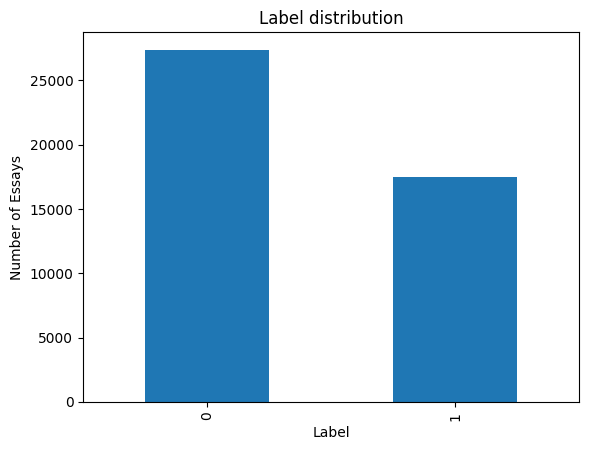

In [3]:
main_df["label"].value_counts().plot(kind="bar",title="Label distribution",xlabel="Label",ylabel="Number of Essays")

In [4]:
llama_falcon_df = pd \
    .read_csv(f"/kaggle/input/llama_falcon_v3.csv") \
    .assign(tokenized_text="") \
    .rename(columns={"generated": "label", "model": "source"})
llama_falcon_df

,text,label,prompt_name,source,tokenized_text
0,One way we can make a positive change is by li...,1,Car-free cities,llama_70b,
1,The experimental district of Vauban in Germany...,1,Car-free cities,llama_70b,
2,"The successful ""Day Without Cars"" event in Bog...",1,Car-free cities,llama_70b,
3,"The exhaust from cars pollutes our air, and th...",1,Car-free cities,llama_70b,
4,"Recently, Paris faced a severe pollution probl...",1,Car-free cities,llama_70b,
...,...,...,...,...,...
6995,"Driverless cars, also known as autonomous cars...",1,Driverless cars,falcon_180b,
6996,Driverless Cars: A Necessity for Our Future\n\...,1,Driverless cars,falcon_180b,
6997,The Pros and Cons of Driverless Cars\n\nThe wo...,1,Driverless cars,falcon_180b,
6998,The development of driverless cars has been a ...,1,Driverless cars,falcon_180b,


In [5]:
data_df = pd.concat([main_df, llama_falcon_df], ignore_index=True)
data_df

,text,label,prompt_name,source,tokenized_text
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,
...,...,...,...,...,...
51863,"Driverless cars, also known as autonomous cars...",1,Driverless cars,falcon_180b,
51864,Driverless Cars: A Necessity for Our Future\n\...,1,Driverless cars,falcon_180b,
51865,The Pros and Cons of Driverless Cars\n\nThe wo...,1,Driverless cars,falcon_180b,
51866,The development of driverless cars has been a ...,1,Driverless cars,falcon_180b,


<Axes: title={'center': 'Label distribution'}, xlabel='Label', ylabel='Number of Essays'>

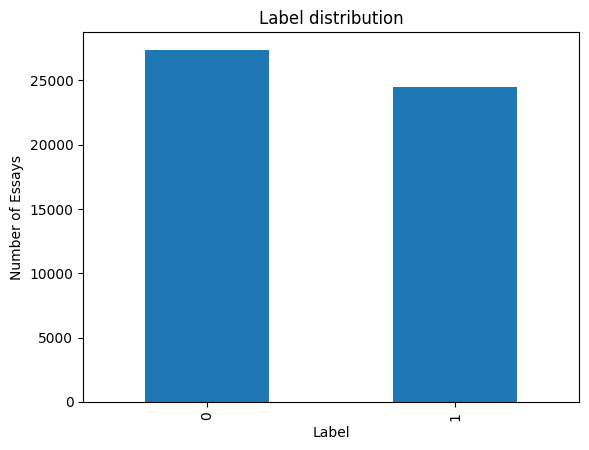

In [6]:
data_df["label"].value_counts().plot(kind="bar",title="Label distribution",xlabel="Label",ylabel="Number of Essays")

In [7]:
# sanity check to make sure there aren't any duplicates introduced
data_df["text"].unique().size

51868

<Axes: title={'center': 'Source distribution'}, xlabel='Text source', ylabel='Count'>

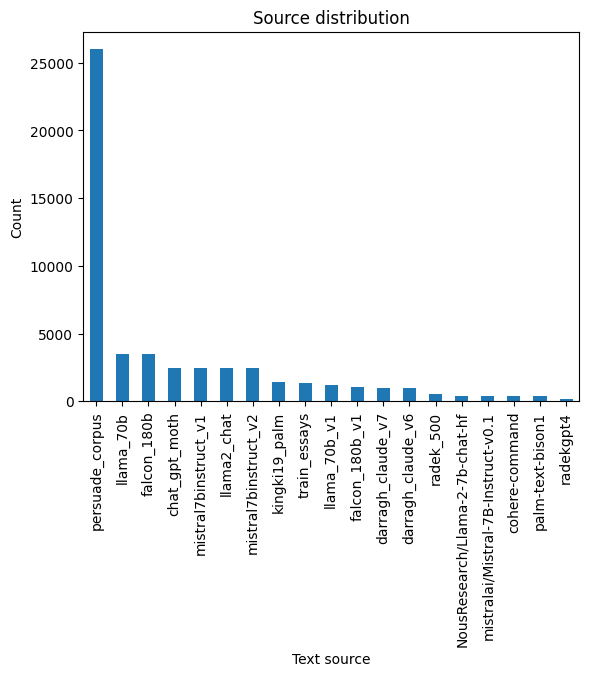

In [8]:
data_df["source"].value_counts().plot(kind="bar", title="Source distribution", xlabel="Text source", ylabel="Count")

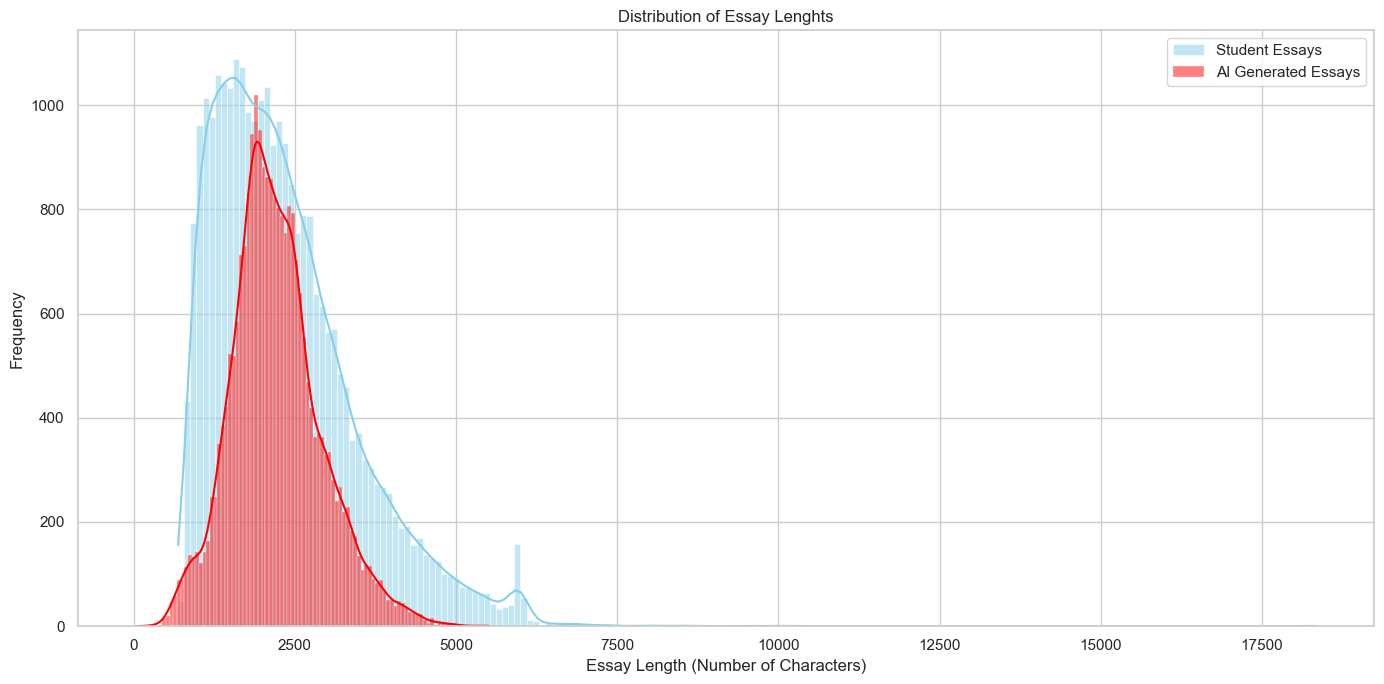

In [9]:
data_df['essay_length'] = data_df['text'].apply(len)

sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))

sns.histplot(data_df[data_df['label']==0]['essay_length'], color='skyblue', label='Student Essays', kde=True)
sns.histplot(data_df[data_df['label']==1]['essay_length'], color='red',label='AI Generated Essays', kde=True)

plt.title('Distribution of Essay Lenghts')
plt.xlabel('Essay Length (Number of Characters)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()

plt.show()

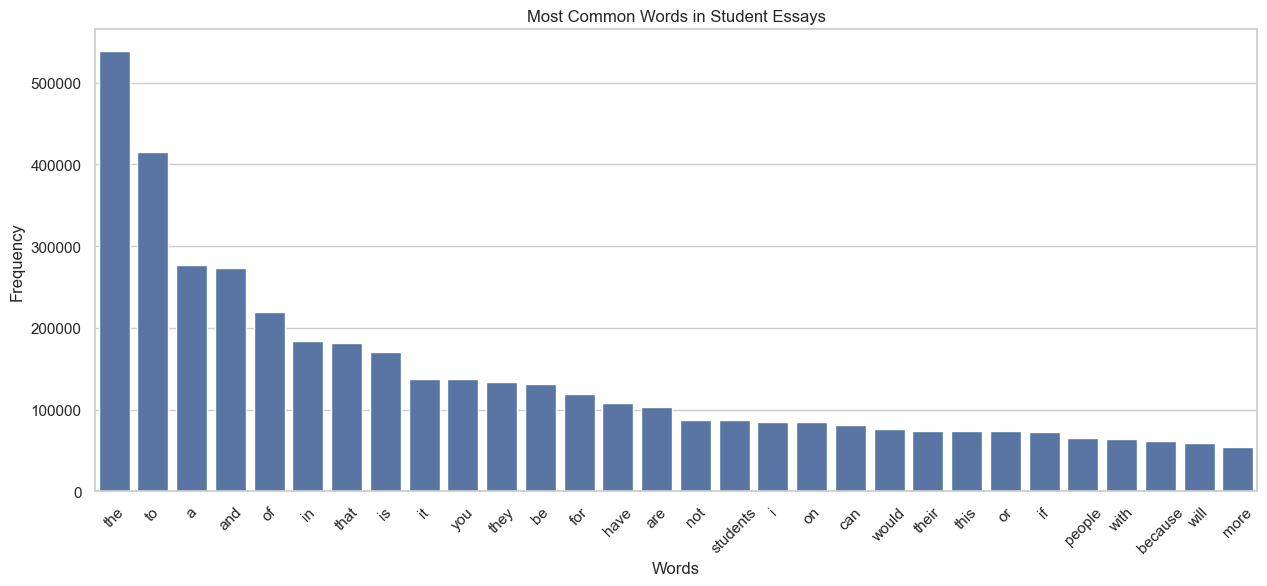

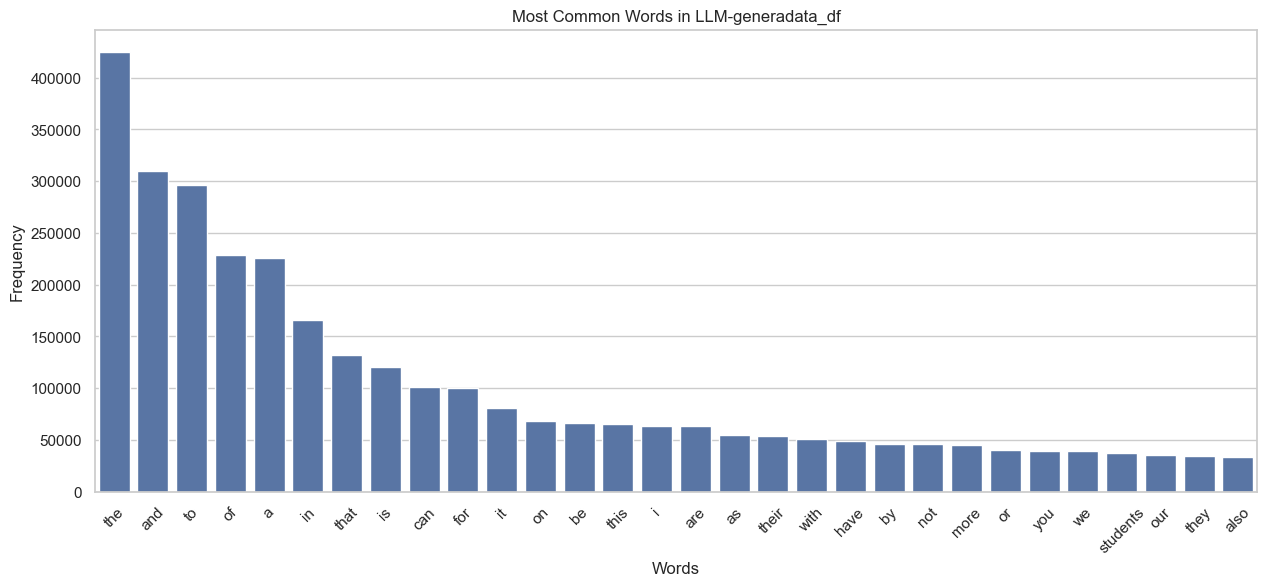

In [10]:
def plot_most_common_words(text_series, num_words=30, title="Most Common Words"):
    all_text = ' '.join(text_series).lower()
    words = all_text.split()
    word_freq = Counter(words)
    common_words = word_freq.most_common(num_words)
    
    plt.figure(figsize=(15, 6))
    sns.barplot(x=[word for word, freq in common_words], y=[freq for word, freq in common_words])
    plt.title(title)
    plt.xticks(rotation=45)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.show()
plot_most_common_words(data_df[data_df['label']==0]['text'], title="Most Common Words in Student Essays")
plot_most_common_words(data_df[data_df['label']==1]['text'], title="Most Common Words in LLM-generadata_df")
    

# Making a validation Dataset 

In [11]:
from sklearn.model_selection import StratifiedKFold
data_df['stratify_key'] = data_df['label'].astype(str) + data_df['source'].astype(str)
k_folds = StratifiedKFold(n_splits=15, shuffle=True, random_state=seed)

for i, (train_idx, valid_idx) in enumerate(k_folds.split(data_df, data_df['stratify_key'])):
    data_df.loc[valid_idx, 'fold'] = i
    
data_df['fold'] = data_df['fold'].astype(int)
data_df

C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=15.
  warnings.warn(


,text,label,prompt_name,source,tokenized_text,essay_length,stratify_key,fold
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,,2029,0persuade_corpus,13
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,,2141,0persuade_corpus,1
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,,1044,0persuade_corpus,0
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,,1243,0persuade_corpus,12
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,,1911,0persuade_corpus,14
...,...,...,...,...,...,...,...,...
51863,"Driverless cars, also known as autonomous cars...",1,Driverless cars,falcon_180b,,2582,1falcon_180b,7
51864,Driverless Cars: A Necessity for Our Future\n\...,1,Driverless cars,falcon_180b,,2772,1falcon_180b,3
51865,The Pros and Cons of Driverless Cars\n\nThe wo...,1,Driverless cars,falcon_180b,,4607,1falcon_180b,6
51866,The development of driverless cars has been a ...,1,Driverless cars,falcon_180b,,3972,1falcon_180b,9


In [12]:
test_df = pd.read_csv(f"/kaggle/input/test_essays.csv").assign(tokenized_text="")
test_df

,id,prompt_id,text,tokenized_text
0,0000aaaa,2,Aaa bbb ccc.,
1,1111bbbb,3,Bbb ccc ddd.,
2,2222cccc,4,CCC ddd eee.,


In [13]:
validation_fold = 12 # arbitrary

valid_df = data_df.loc[data_df["fold"] == validation_fold]
valid_df

,text,label,prompt_name,source,tokenized_text,essay_length,stratify_key,fold
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,,1243,0persuade_corpus,12
15,Although cell phones have been around for quit...,0,Phones and driving,persuade_corpus,,3002,0persuade_corpus,12
17,Phones & Driving\n\nCell phones have become ve...,0,Phones and driving,persuade_corpus,,1475,0persuade_corpus,12
19,Should Drivers Be Allowed To Use Cell Phones W...,0,Phones and driving,persuade_corpus,,2483,0persuade_corpus,12
79,"Ever since phones have entered into the world,...",0,Phones and driving,persuade_corpus,,2840,0persuade_corpus,12
...,...,...,...,...,...,...,...,...
51772,"Driverless cars, a new form of technology that...",1,Driverless cars,falcon_180b,,2413,1falcon_180b,12
51776,Introduction\n\nDriverless cars have generated...,1,Driverless cars,falcon_180b,,2361,1falcon_180b,12
51795,Driverless cars have garnered significant atte...,1,Driverless cars,falcon_180b,,3207,1falcon_180b,12
51798,Introduction\n\nDriverless cars are an emergin...,1,Driverless cars,falcon_180b,,2876,1falcon_180b,12


In [14]:
train_df = data_df.loc[data_df["fold"] != validation_fold]
train_df

,text,label,prompt_name,source,tokenized_text,essay_length,stratify_key,fold
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,,2029,0persuade_corpus,13
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,,2141,0persuade_corpus,1
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,,1044,0persuade_corpus,0
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,,1911,0persuade_corpus,14
5,Cell phone use should not be legal while drivi...,0,Phones and driving,persuade_corpus,,2887,0persuade_corpus,9
...,...,...,...,...,...,...,...,...
51863,"Driverless cars, also known as autonomous cars...",1,Driverless cars,falcon_180b,,2582,1falcon_180b,7
51864,Driverless Cars: A Necessity for Our Future\n\...,1,Driverless cars,falcon_180b,,2772,1falcon_180b,3
51865,The Pros and Cons of Driverless Cars\n\nThe wo...,1,Driverless cars,falcon_180b,,4607,1falcon_180b,6
51866,The development of driverless cars has been a ...,1,Driverless cars,falcon_180b,,3972,1falcon_180b,9


# PreProcessing Data

In [15]:
from tqdm.auto import tqdm
from time import time

from tokenizers import (
    Tokenizer
)
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import ByteLevel
from tokenizers.normalizers import Sequence, NFC
from datasets import Dataset
from transformers import PreTrainedTokenizerFast

from sklearn.feature_extraction.text import TfidfVectorizer

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [16]:

bpe = Tokenizer(BPE(unk_token="[UNK]"))
bpe.normalizer = Sequence([NFC()])
bpe.pre_tokenizer = ByteLevel()

all_text = train_df["text"].tolist()
all_text += valid_df["text"].tolist()
all_text += test_df["text"].tolist()

bpe_trainer = BpeTrainer(vocab_size=30522, special_tokens=["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"])
bpe.train_from_iterator(all_text, trainer=bpe_trainer)

tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=bpe,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)


In [ ]:
for idx, row in tqdm(train_df.iterrows()):
    train_df.at[idx, "tokenized_text"] = tokenizer.tokenize(row["text"])

for idx, row in tqdm(valid_df.iterrows()):
    valid_df.at[idx, "tokenized_text"] = tokenizer.tokenize(row["text"])

for idx, row in tqdm(test_df.iterrows()):
    test_df.at[idx, "tokenized_text"] = tokenizer.tokenize(row["text"])

0it [00:00, ?it/s]

In [ ]:
train_dataset = Dataset.from_pandas(train_df[["tokenized_text", "label"]])
valid_dataset = Dataset.from_pandas(valid_df[["tokenized_text", "label"]])
test_dataset = Dataset.from_pandas(test_df[["tokenized_text"]])

In [ ]:

vocab_vectorizer = TfidfVectorizer(ngram_range=n_grams,
                                   lowercase=False, 
                                   sublinear_tf=True, 
                                   analyzer="word", 
                                   tokenizer=lambda x: x, 
                                   preprocessor=lambda x:x, 
                                   token_pattern=None, 
                                   strip_accents="unicode")

vocab_corpus = valid_dataset[:]["tokenized_text"]
vocab_corpus += test_dataset[:]["tokenized_text"]
vocab_vectorizer.fit(vocab_corpus)
vocab = vocab_vectorizer.vocabulary_

In [ ]:
len(vocab)

# Creating The Model

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=n_grams, 
                             lowercase=False, 
                             sublinear_tf=True,
                             vocabulary=vocab, 
                             analyzer="word", 
                             tokenizer=lambda x: x, 
                             preprocessor=lambda x: x, 
                             token_pattern=None, 
                             strip_accents="unicode")
vectorizer.fit(valid_dataset[:]["tokenized_text"] + test_dataset[:]["tokenized_text"])

In [ ]:
train_X, train_Y = vectorizer.transform(train_dataset[:]["tokenized_text"]), np.array(train_dataset[:]["label"])

In [ ]:
valid_X, valid_Y = vectorizer.transform(valid_dataset[:]["tokenized_text"]), np.array(valid_dataset[:]["label"])

In [ ]:
model = SGDClassifier(loss="modified_huber",tol=1e-5,max_iter=99999)
model.fit(train_X, train_Y)


In [ ]:
train_preds = model.predict(train_X)
\
train_proba = model.predict_proba(train_X)
train_matches = train_preds == train_Y
train_corrects = np.where(train_matches == True)[0]
train_incorrects = np.where(train_matches == False)[0]
train_tns = np.where(np.logical_and((train_matches == True),(train_preds == 0)))[0]
train_tps = np.where(np.logical_and((train_matches == True),(train_preds == 1)))[0]
train_fns = np.where(np.logical_and((train_matches == False),(train_preds == 0)))[0]
train_fps = np.where(np.logical_and((train_matches == False),(train_preds == 1)))[0]
print(f"Training statistics")
print(f"Total incorrect: {train_incorrects.shape[0]} / {train_preds.shape[0]}")
print(f"False negatives: {train_fns.shape[0]}")
print(train_proba[train_fns])
print(f"False positives: {train_fps.shape[0]}")

valid_preds = model.predict(valid_X)
valid_proba = model.predict_proba(valid_X)
valid_matches = valid_preds == valid_Y
valid_corrects = np.where(valid_matches == True)[0]
valid_incorrects = np.where(valid_matches == False)[0]
valid_tns = np.where(np.logical_and((valid_matches == True),(valid_preds == 0)))[0]
valid_tps = np.where(np.logical_and((valid_matches == True),(valid_preds == 1)))[0]
valid_fns = np.where(np.logical_and((valid_matches == False),(valid_preds == 0)))[0]
valid_fps = np.where(np.logical_and((valid_matches == False),(valid_preds == 1)))[0]
print(f"Validation statistics")
print(f"Total incorrect: {valid_incorrects.shape[0]} / {valid_preds.shape[0]}")
print(f"False negatives: {valid_fns.shape[0]}")
print(valid_proba[valid_fns])
print(f"False positives: {valid_fps.shape[0]}")

print("")
print(f"Accuracy: {accuracy_score(valid_Y, valid_preds)}")